In [172]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
# import aesara as asr
from aesara import shared
import pytensor

az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [173]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ

['005930',
 '005935',
 '000660',
 '006400',
 '006405',
 '051910',
 '051915',
 '005380',
 '005385',
 '035420',
 '068270',
 '000270',
 '035720',
 '105560',
 '005490',
 '055550',
 '207940',
 '012330',
 '373220',
 '028260',
 '086790',
 '033780',
 '066570',
 '066575',
 '096770',
 '316140',
 '017670',
 '034730',
 '003550',
 '030200',
 '009150',
 '259960',
 '036570',
 '323410',
 '000810',
 '009830',
 '015760',
 '032830',
 '051900',
 '010130',
 '011200',
 '003490',
 '034020',
 '003670',
 '011070',
 '018260',
 '402340',
 '028050',
 '009540',
 '010950',
 '010140',
 '352820',
 '047810',
 '097950',
 '090430',
 '034220',
 '021240',
 '000100',
 '035250',
 '086280',
 '032640',
 '251270',
 '000720',
 '011170',
 '267250',
 '004020',
 '024110',
 '161390',
 '377300',
 '010620',
 '005830',
 '011780',
 '008770',
 '383220',
 '271560',
 '006800',
 '329180',
 '071050',
 '012450',
 '018880',
 '078930',
 '016360',
 '011790',
 '001450',
 '139480',
 '010060',
 '128940',
 '138930',
 '004170',
 '030000',
 '302440',

In [174]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [179]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); p.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-04,63600,53700,84500,726000,331000,722000,323500,183800,94100,201000,...,172700,80200,8940,15650,32675,12985,14680,12925,11890,111955
2023-04-05,63900,53800,84600,778000,345500,732000,327500,186700,94900,199200,...,171200,79900,8930,15410,32860,13320,14745,13225,11830,111955
2023-04-06,62300,53100,83800,745000,338000,716000,318000,185100,94200,191900,...,171000,79900,8950,15060,32275,13240,14570,13150,11900,112370
2023-04-07,65000,54800,89100,738000,338000,714000,321000,185100,93600,193400,...,170200,80600,9050,15110,32825,13625,14570,13165,11885,112245
2023-04-10,65700,55800,90700,749000,343000,750000,341500,185900,94000,193000,...,169700,79900,8940,16210,33140,14055,14665,13015,11915,112700


In [176]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-04,63400,53800,85700,740000,337000,717000,320500,184000,94700,198200,...,173500,80200,8730,15570,32555,12910,14615,12955,11820,111680
2023-04-05,63700,53300,84300,730000,343500,722000,323500,185100,94100,201000,...,172300,80600,8900,15730,32680,13015,14695,13195,11860,111960
2023-04-06,63500,53400,83900,764000,345500,728000,327000,186900,94900,198200,...,171500,79900,8940,15400,32720,13350,14610,13190,11900,112120
2023-04-07,63800,54100,87900,742000,340000,720000,321000,185400,94300,193000,...,171100,80200,8950,15090,32510,13210,14630,13115,11920,113300
2023-04-10,64800,54700,88700,738000,338500,721000,326000,186000,94000,193300,...,170200,80900,9050,15380,32805,13625,14680,13090,11910,112310


In [250]:
pairs = [
    ['005930', '005935'], # 삼성전자
    ['066570', '066575'], # LG전자
    ['006400', '006405'], # 삼성SDI
    ['051910', '051915'], # LG화학
    ['005380', '005385'], # 현대차
]

_from, _to = '2019-01-01', '2023-04-7'

stock1_name, stock2_name = pairs[3]
orig_data = logp.loc[_from:_to,[stock1_name, stock2_name]]
p_data = p.loc[_from:_to,[stock1_name, stock2_name]]
p_open_data = p_open.loc[_from:_to,[stock1_name, stock2_name]]

data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

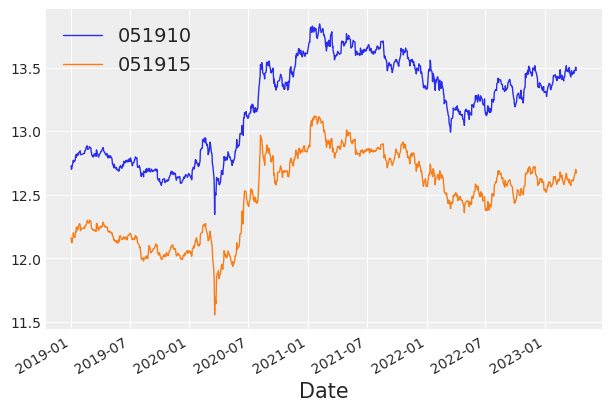

In [251]:
plt.figure(figsize = (6,4))
ax = plt.gca()
# plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,linewidth=1, fontsize=10)
orig_data[stock2_name].plot(ax=ax,linewidth=1, fontsize=10)
# plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

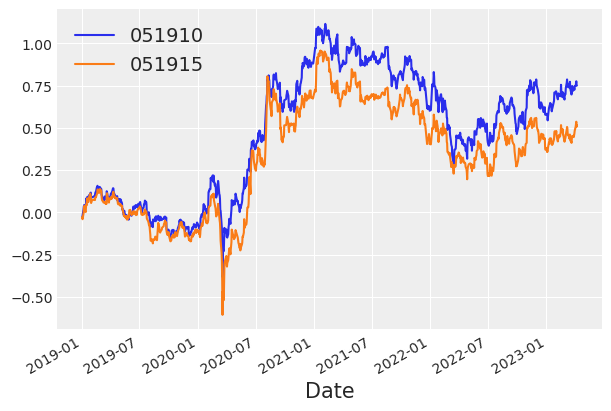

In [252]:
data[[stock1_name, stock2_name]].plot(figsize=(6,4), fontsize=10)

In [253]:
data.shape

(1055, 2)

In [254]:
with pm.Model() as model:
    
#     stock1 = data1
#     stock2 = data2
    
    stock1 = pytensor.shared(data1)
    stock2 = pytensor.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, shape=data1.shape[0], init_dist=pm.Normal.dist(0, 10))
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)

with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    idata = pm.sample(chains=2, cores=8, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [beta_sigma, beta, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [429]:
# with pm.Model() as model:
#     model.add_coord('dates', data.index[:250], mutable = True)
#     stock1 = pm.MutableData('stock1', data1[:250], dims='dates')
#     stock2 = pm.MutableData('stock2', data2[:250], dims='dates')
    
#     beta_sigma = pm.Exponential('beta_sigma', 50.)
#     beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, init_dist=pm.Normal.dist(0, 10), dims='dates')
    
#     stock2_regression = beta * stock1
#     sd = pm.HalfNormal('sd', sigma=.1)
#     likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)
    
#     idata = pm.sample(chains=2, cores=8, random_seed=0)
    
    
# with model:
#     for i in range(2):
#         pm.set_data({
#             'stock1': [data1[600]],
#             'stock2': [data2[600]]
#         }, coords={ 'dates': [600] })

#     #     idata.extend(pm.sample_posterior_predictive(idata))
# #         idata2 = pm.sample(chains=2, cores=8, random_seed=0)
#         idata3 = pm.sample_prior_predictive(samples=1000, random_seed=0)    

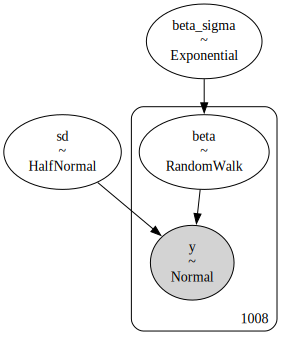

In [239]:
pm.model_to_graphviz(model)

In [255]:
# rolling_beta = idata.posterior['beta'].T.mean(axis=1)[:,0]#.mean(axis=1)
rolling_beta = idata.posterior['beta'].mean(dim=['draw','chain'])

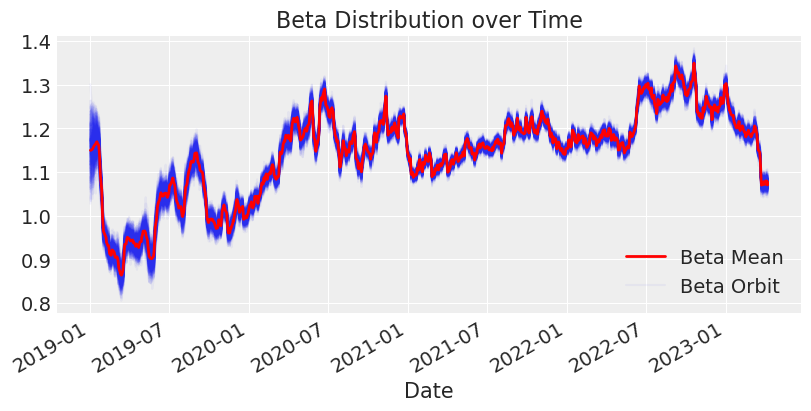

In [164]:
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)

for orbit in idata.posterior['beta'].sel(draw=slice(0,300))[0]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
    

plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

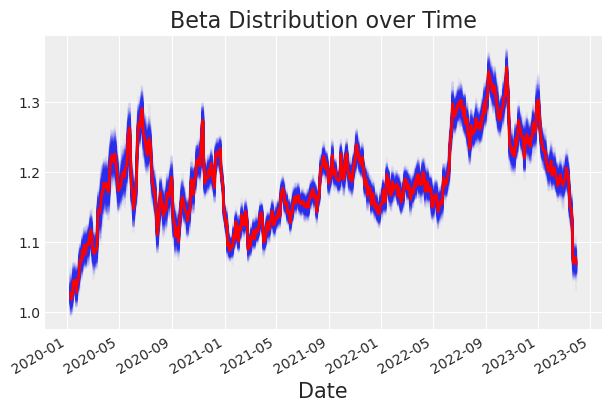

In [106]:
plt.figure(figsize = (6,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta[250:],index=orig_data.index[250:]).plot(ax=ax,color='r',zorder=1e6,linewidth=2, fontsize=10)

for orbit in idata.posterior['beta'].sel(draw=slice(0,300))[0]:
    pd.Series(orbit[250:],index=orig_data.index[250:]).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05, fontsize=10)
    

# plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

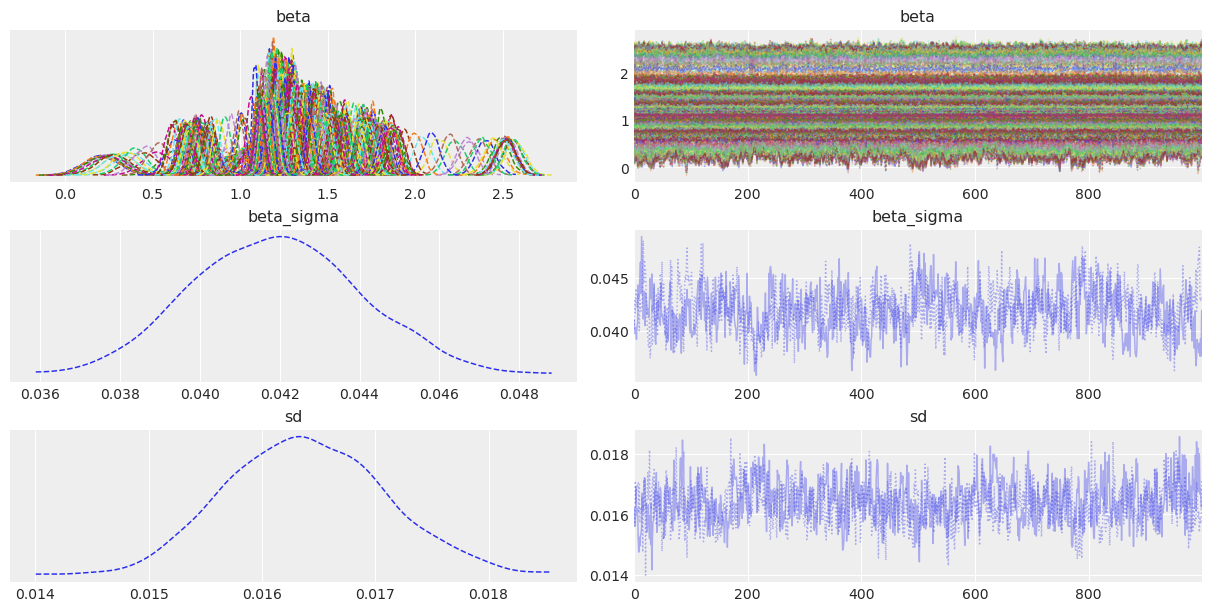

In [21]:
az.plot_trace(idata, combined=True);

In [233]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()
            
            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = np.sign(w0 / w_max)
                leverage.iloc[i,1] = np.sign(w1 / w_max)
                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [234]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            #set_trace()
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (portfolioWeights.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

In [41]:
portfolioWeights, signal = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)#.fillna(0)
# portfolioWeights.plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

<Axes: xlabel='Date'>

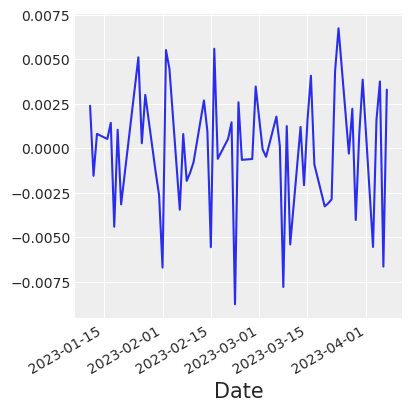

In [186]:
signal0.tail(60).plot(fontsize=10, figsize=(4,4))

In [218]:
#portfolioWeights.sum(axis=1).plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

# 삼성전자

테스트 일수: 806일
순손익 (투자금액대비%): 17,696,370원 (17.696%)
총비용 (총손익대비%): 20,985,679원 (54.252%)
진입횟수: 91회
월평균 진입횟수: 2.26회
진입일수 (전체일수대비%): 184일 (22.83%)
평균보유일수: 2.02일
진입당 평균손익: 194,465원
최대수익: 2,822,662원
최대손실: -1,909,085원
수익진입의 평균수익: 769,270원
손실진입의 평균손실: -419,530원


<Axes: xlabel='Date'>

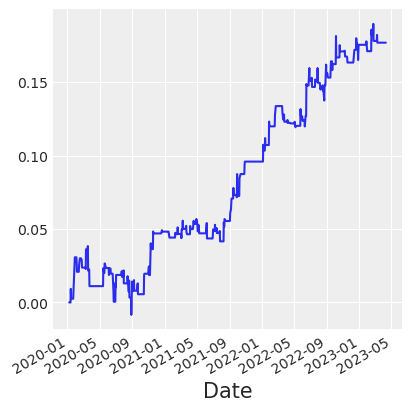

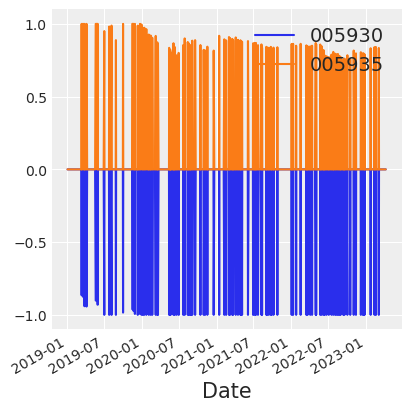

In [188]:
w0, signal0 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares0, cash0, returns0, values0, pnl_hist0, pnl0 = backtest(p_data[250:], p_open_data[250:], w0[250:], 1e8)
returns0.plot(figsize=(4,4), fontsize=10)
w0.plot(figsize=(4,4), fontsize=10)

In [189]:
w0.tail()

,005930,005935
Date,,
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0
2023-04-10,0.0,0.0


<Axes: >

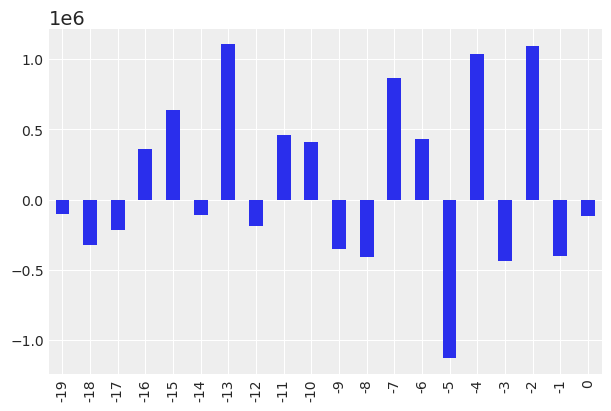

In [190]:
_pnl = pnl0.iloc[-20:]#.plot.bar()
_pnl.index = list(range(-19,1))
_pnl.plot.bar(figsize=(6,4), fontsize=10)

# LG전자

테스트 일수: 806일
순손익 (투자금액대비%): 36,098,913원 (36.099%)
총비용 (총손익대비%): 19,433,936원 (34.995%)
진입횟수: 84회
월평균 진입횟수: 2.08회
진입일수 (전체일수대비%): 184일 (22.83%)
평균보유일수: 2.19일
진입당 평균손익: 429,748원
최대수익: 3,165,459원
최대손실: -4,143,182원
수익진입의 평균수익: 1,253,581원
손실진입의 평균손실: -843,446원


<Axes: xlabel='Date'>

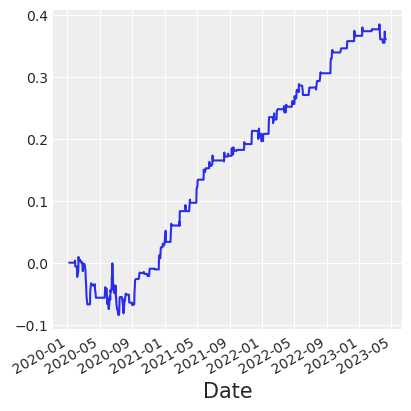

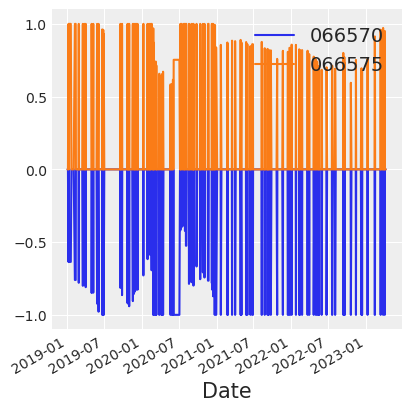

In [197]:
w1, signal1 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares1, cash1, returns1, values1, pnl_hist1, pnl1 = backtest(p_data[250:], p_open_data[250:], w1[250:], 1e8)
returns1.plot(figsize=(4,4), fontsize=10)
w1.plot(figsize=(4,4), fontsize=10)

In [198]:
w1.tail()

,066570,066575
Date,,
2023-04-04,0.0,0.000000
2023-04-05,-1.0,0.951415
2023-04-06,0.0,0.000000
2023-04-07,0.0,0.000000
2023-04-10,0.0,0.000000


# 삼성SDI

테스트 일수: 806일
순손익 (투자금액대비%): 85,261,574원 (85.262%)
총비용 (총손익대비%): 16,984,025원 (16.611%)
진입횟수: 80회
월평균 진입횟수: 1.99회
진입일수 (전체일수대비%): 184일 (22.83%)
평균보유일수: 2.30일
진입당 평균손익: 1,065,769원
최대수익: 11,341,820원
최대손실: -3,621,398원
수익진입의 평균수익: 1,786,210원
손실진입의 평균손실: -1,095,554원


<Axes: xlabel='Date'>

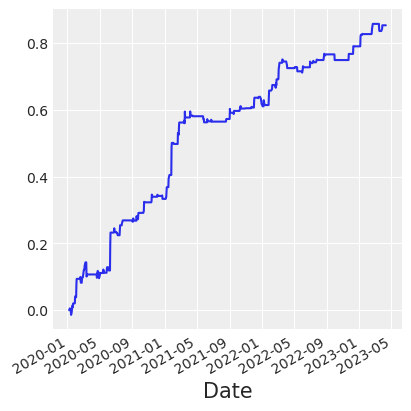

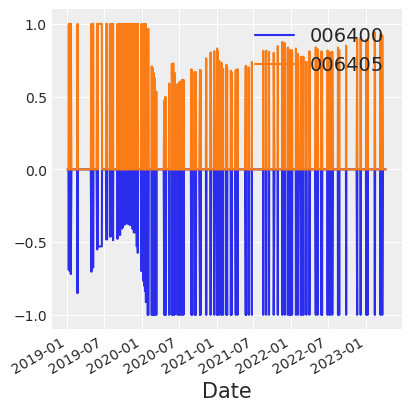

In [205]:
w2, signal2 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares2, cash2, returns2, values2, pnl_hist2, pnl2 = backtest(p_data[250:], p_open_data[250:], w2[250:], 1e8)
returns2.plot(figsize=(4,4), fontsize=10)
w2.plot(figsize=(4,4), fontsize=10)

In [206]:
w2.tail()

,006400,006405
Date,,
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0
2023-04-10,0.0,0.0


# LG화학

테스트 일수: 806일
순손익 (투자금액대비%): 87,914,084원 (87.914%)
총비용 (총손익대비%): 25,280,415원 (22.334%)
진입횟수: 97회
월평균 진입횟수: 2.41회
진입일수 (전체일수대비%): 184일 (22.83%)
평균보유일수: 1.90일
진입당 평균손익: 906,330원
최대수익: 23,478,151원
최대손실: -8,645,786원
수익진입의 평균수익: 2,200,321원
손실진입의 평균손실: -1,663,080원


<Axes: xlabel='Date'>

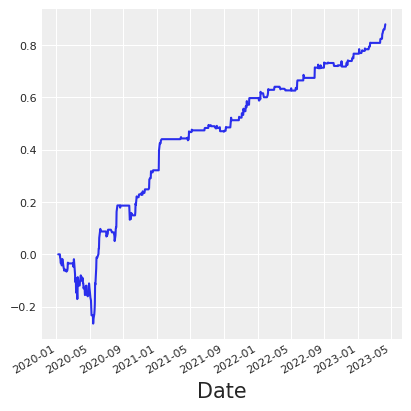

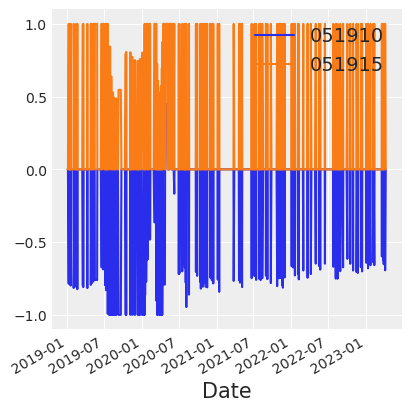

In [213]:
w3, signal3 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares3, cash3, returns3, values3, pnl_hist3, pnl3 = backtest(p_data[250:], p_open_data[250:], w3[250:], 1e8)
returns3.plot(figsize=(4,4), fontsize=8)
w3.plot(figsize=(4,4), fontsize=10)

테스트 일수: 805일
순손익 (투자금액대비%): 81,548,933원 (81.549%)
총비용 (총손익대비%): 26,239,566원 (24.344%)
진입횟수: 96회
월평균 진입횟수: 2.39회
진입일수 (전체일수대비%): 184일 (22.86%)
평균보유일수: 1.92일
진입당 평균손익: 849,468원
최대수익: 24,456,655원
최대손실: -11,136,853원
수익진입의 평균수익: 2,295,510원
손실진입의 평균손실: -1,787,433원


<Axes: xlabel='Date'>

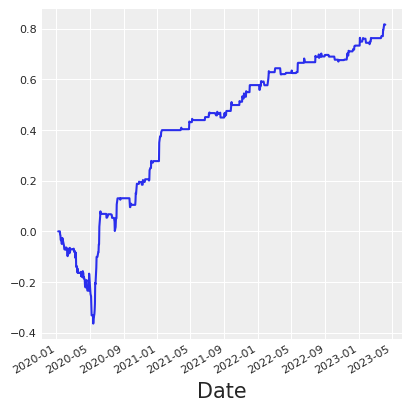

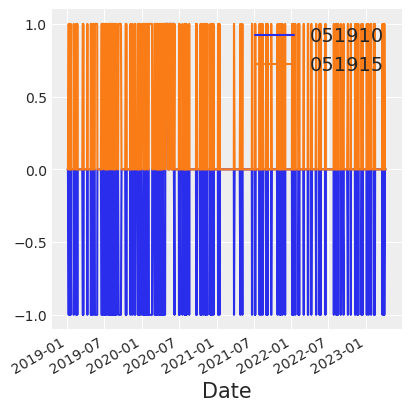

In [256]:
w3, signal3 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares3, cash3, returns3, values3, pnl_hist3, pnl3 = backtest(p_data[250:], p_open_data[250:], w3[250:], 1e8)
returns3.plot(figsize=(4,4), fontsize=8)
w3.plot(figsize=(4,4), fontsize=10)

In [214]:
w3.tail()

,051910,051915
Date,,
2023-04-04,0.000000,0.0
2023-04-05,0.000000,0.0
2023-04-06,0.000000,0.0
2023-04-07,-0.693769,1.0
2023-04-10,0.000000,0.0


In [257]:
w3.tail()

,051910,051915
Date,,
2023-04-03,0.0,0.0
2023-04-04,0.0,0.0
2023-04-05,0.0,0.0
2023-04-06,0.0,0.0
2023-04-07,0.0,0.0


# 현대차

테스트 일수: 806일
순손익 (투자금액대비%): 39,546,968원 (39.547%)
총비용 (총손익대비%): 25,910,631원 (39.584%)
진입횟수: 100회
월평균 진입횟수: 2.48회
진입일수 (전체일수대비%): 184일 (22.83%)
평균보유일수: 1.84일
진입당 평균손익: 395,469원
최대수익: 9,824,553원
최대손실: -4,021,175원
수익진입의 평균수익: 1,143,115원
손실진입의 평균손실: -824,372원


<Axes: xlabel='Date'>

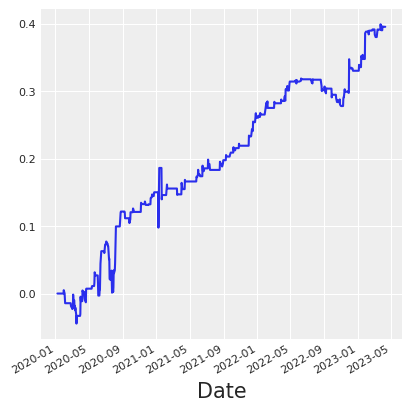

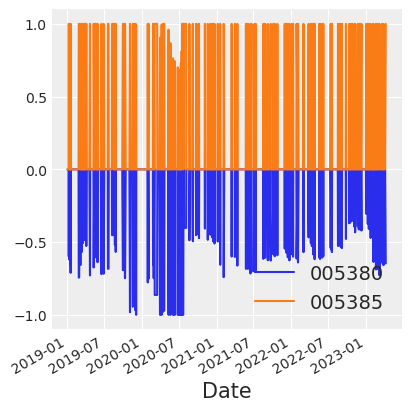

In [229]:
w4, signal4 = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)
shares4, cash4, returns4, values4, pnl_hist4, pnl4 = backtest(p_data[250:], p_open_data[250:], w4[250:], 1e8)
returns4.plot(figsize=(4,4), fontsize=8)
w4.plot(figsize=(4,4), fontsize=10)

In [222]:
w4.tail()

,005380,005385
Date,,
2023-04-04,0.000000,0.0
2023-04-05,0.000000,0.0
2023-04-06,0.000000,0.0
2023-04-07,0.000000,0.0
2023-04-10,-0.646105,1.0


In [226]:
notional = 50000000
(notional * w4.iloc[-1] / p_data.iloc[-1]).astype(int)

005380   -173
005385    531
Name: 2023-04-10 00:00:00, dtype: int32

In [228]:
173*185900, 531*94000

(32160700, 49914000)

# 삼성SDI + LG화학 + 현대차

<Axes: xlabel='Date'>

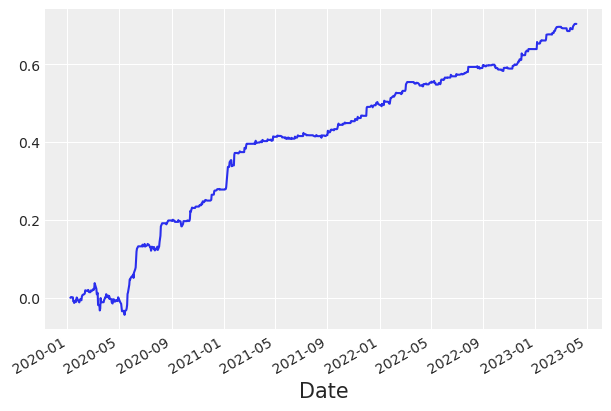

In [65]:
total_values = values2 + values3 + values4
((total_values / total_values.iloc[0]) - 1).plot(fontsize=10, figsize=(6,4))

<Axes: >

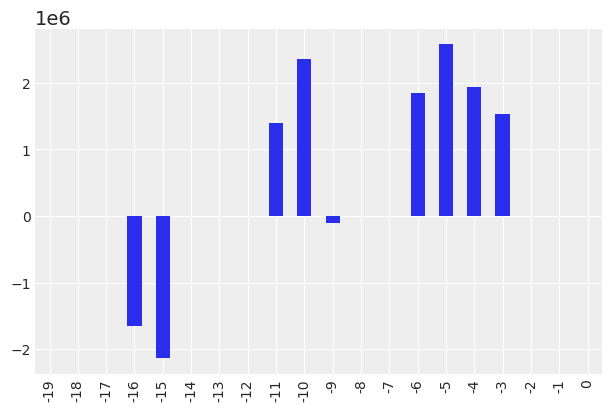

In [76]:
_pnl_total = (pnl_hist2 + pnl_hist3 + pnl_hist4).iloc[-20:]
_pnl_total.index = list(range(-19,1))
_pnl_total.plot.bar(figsize=(6,4), fontsize=10)

In [267]:
mu = 2.4
poisson = pm.Poisson.dist(mu)
pm.draw(poisson, 1000)

array([2, 4, 4, 3, 3, 3, 4, 3, 2, 4, 1, 3, 2, 1, 2, 2, 2, 4, 2, 3, 1, 2,
       2, 4, 2, 0, 3, 1, 3, 1, 3, 6, 2, 1, 1, 4, 1, 3, 2, 3, 2, 1, 2, 0,
       2, 2, 4, 1, 3, 2, 2, 5, 4, 3, 1, 2, 3, 2, 5, 4, 3, 6, 3, 3, 3, 2,
       1, 0, 3, 2, 2, 2, 4, 3, 2, 4, 4, 2, 2, 4, 0, 2, 3, 5, 0, 3, 3, 3,
       3, 2, 3, 1, 4, 1, 2, 3, 0, 2, 2, 1, 2, 5, 1, 2, 2, 0, 1, 1, 4, 4,
       0, 2, 3, 1, 0, 0, 1, 4, 1, 1, 3, 0, 3, 4, 3, 1, 4, 3, 1, 2, 2, 1,
       0, 0, 1, 2, 0, 2, 0, 2, 5, 4, 2, 3, 4, 2, 2, 3, 3, 2, 1, 3, 2, 3,
       2, 3, 2, 2, 3, 3, 3, 4, 5, 3, 6, 1, 5, 5, 2, 2, 2, 2, 4, 4, 4, 0,
       3, 2, 4, 1, 1, 0, 2, 2, 2, 0, 3, 3, 5, 0, 1, 1, 0, 4, 2, 2, 3, 4,
       2, 5, 3, 3, 1, 1, 1, 5, 2, 1, 2, 3, 1, 3, 6, 5, 3, 5, 5, 3, 2, 3,
       1, 1, 4, 2, 1, 3, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 4, 4, 6, 3, 7,
       1, 4, 1, 1, 4, 2, 3, 2, 2, 1, 0, 2, 3, 3, 2, 2, 1, 0, 4, 4, 1, 2,
       1, 4, 3, 0, 3, 4, 5, 3, 2, 1, 3, 1, 1, 3, 2, 3, 1, 4, 1, 0, 4, 2,
       5, 2, 3, 3, 1, 1, 1, 2, 5, 3, 2, 2, 2, 1, 4,